<h2>Расшифровка данных таблицы</h2>
<ol>
<li>Дата и время: Временной интервал в десять минут.</li>
<li>Температура: Температура погоды.</li>
<li>Влажность: Влажность воздуха.</li>
<li>Скорость ветра: Скорость ветра.</li>
<li>Общие сведения Диффузные потоки: “Диффузный поток” - это общий термин для описания низкотемпературных (от < 0,2° до ~ 100°C) флюидов, которые медленно вытекают через сульфидные насыпи, трещиноватые потоки лавы и скопления бактериальных матов и макрофауны.</li>
<li>Рассеянные потоки</li>
<li>Зона 1 Энергопотребления</li>
<li>Зона 2 энергопотребления</li>
<li>Зона 3 энергопотребления</li>
</ol>

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from src.BaseNetwork import BaseNetwork
from models.rnn import LSTM, RNNModel, MLP, LSTMModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('powerconsumption.csv')
data.head()
# Преобразуем дату в формат datetime и установим индекс
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)
data_copy = data.drop(columns=['PowerConsumption_Zone2', 'PowerConsumption_Zone3'])
# Нормализуем данные
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['PowerConsumption_Zone2', 'PowerConsumption_Zone3']))

# Преобразуем обратно в DataFrame для удобства
scaled_data = pd.DataFrame(scaled_data, columns=data_copy.columns, index=data_copy.index)

# Разделим на входные признаки (X) и целевую переменную (y)
X = scaled_data.drop(columns=['PowerConsumption_Zone1'])
y = scaled_data['PowerConsumption_Zone1']

# Разделим данные на обучающую и тестовую выборки


In [9]:
import yaml
config_path = 'configs/rnn.yaml'

def read_config(path: str) -> dict:
        with open(path, 'r') as file:
            config = yaml.safe_load(file)
        return config
config = read_config(config_path)

In [10]:
from src.BaseNetwork_clone import BaseNetwork

model_pipeline = BaseNetwork(
    config_path=config_path,
    model=LSTMModel(config['UserConfig']),
    data=X.values,
    target=y.values
)

Logging configuration loaded successfully
2024-11-21 14:59:03,736 - BaseNetwork - INFO - Logger successfully initialized!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Константы
SEQ_LENGTH = 30  # длина последовательности для LSTM
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_loader = DataLoader(model_pipeline.train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(model_pipeline.eval_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Константы
SEQ_LENGTH = 30  # длина последовательности для LSTM
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Подготовка данных для LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.seq_length]
        y_seq = self.y[idx + self.seq_length]
        return X_seq, y_seq

# Создаем датасеты
train_dataset = TimeSeriesDataset(X_train, y_train, SEQ_LENGTH)
test_dataset = TimeSeriesDataset(X_test, y_test, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Определение модели
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # берем последний временной шаг
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(DEVICE)

# Оптимизатор и функция потерь
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Обучение модели
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss:.4f}")

# Оценка модели
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/5, Loss: 0.0215
Epoch 2/5, Loss: 0.0316
Epoch 3/5, Loss: 0.0311
Epoch 4/5, Loss: 0.0315
Epoch 5/5, Loss: 0.0315


In [13]:
BATCH_SIZE = 1

In [14]:
# Сохраним предсказания и реальные значения
all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        y_pred = model(X_batch)
        
        # Сохраняем предикты и метки
        all_preds.append(y_pred.cpu().numpy())
        all_true.append(y_batch.cpu().numpy())

# Преобразуем списки в массивы
all_preds = np.concatenate(all_preds, axis=0)
all_true = np.concatenate(all_true, axis=0)

# Обратное масштабирование
all_preds_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((all_preds.shape[0], X.shape[1])), all_preds], axis=1)
)[:, -1]  # берем только колонку с предсказаниями

all_true_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((all_true.shape[0], X.shape[1])), all_true.reshape(-1, 1)], axis=1)
)[:, -1]  # берем только колонку с истинными значениями


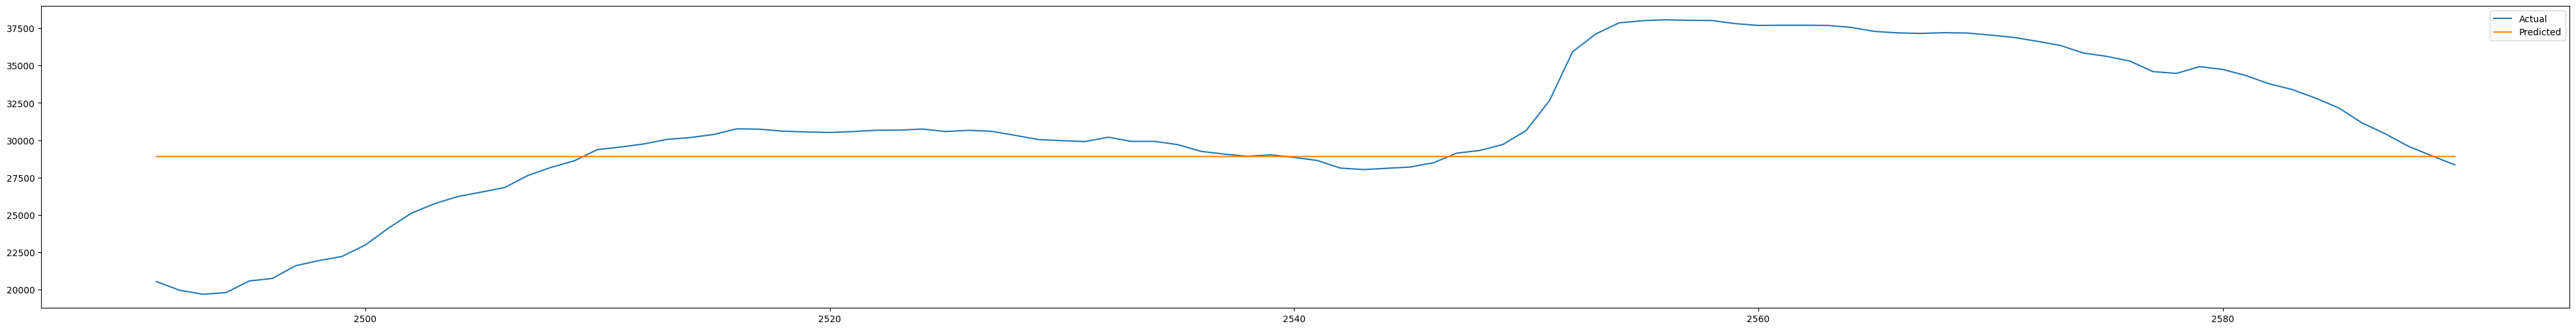

In [15]:
plt.figure(figsize=(50, 6))
plt.plot(range(len(all_preds_rescaled))[-100:], all_true_rescaled[-100:], label='Actual')
plt.plot(range(30, len(all_preds_rescaled))[-100:], all_preds_rescaled[-100:], label='Predicted')
plt.legend()
plt.show()